In [1]:
# read dataset one image

# image_size=128, batch_size:256, epochs=10, drop_out=0.25,0.5, score=2.6896452718267965e-05
# image_size=128, batch_size:128, epochs=10, drop_out=0.25,0.5, score=2.0310855384028685e-05
# image_size=128, batch_size:128, epochs=20, drop_out=0.25,0.5, score=1.1700560265438025e-06

from keras.preprocessing import image

imageSize = 128
batch_size = 128
is_debug = False

def readImage(path):
    img = image.load_img(path, target_size=(imageSize, imageSize))
    x = image.img_to_array(img)
    x = x.astype('float32')
    x /= 255
    return x

/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/matplotlib/__init__.py:1067: UserWarning: Duplicate key in file "/home/ubuntu/.config/matplotlib/matplotlibrc", line #2
  (fname, cnt))
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/matplotlib/__init__.py:1067: UserWarning: Duplicate key in file "/home/ubuntu/.config/matplotlib/matplotlibrc", line #3
  (fname, cnt))


In [2]:
def getLabel(path):
    name = path[path.rfind('/') + 1:path.index('.')]
#     print (name)
    return 1 if name == 'dog' else 0
print ("getLabel done")

getLabel done


In [3]:
import helper

def readFeatureAndLabel():
    train_files = helper.get_train_files()
    file_count = 1024 if is_debug else len(train_files)
    print("readFeatureAndLabel file_count=" + str(file_count))
    train_feature = []
    train_label = []
    for i in range(file_count):
        f = train_files[i]
#         print (f)
        train_feature.append(readImage(f))
        train_label.append(getLabel(f))
    
    return train_feature, train_label

In [4]:
import numpy as np

total_feature, total_label = readFeatureAndLabel()
total_feature = np.array(total_feature)
# total_feature = total_feature.astype('float32')
# total_feature /= 255

total_label = np.array(total_label)
# print (total_label)

readFeatureAndLabel file_count=25000


In [5]:
# split train_feature, train_label, validation_feature, validation_label
from sklearn.model_selection import train_test_split
train_feature, validation_feature, train_label, validation_label = train_test_split(total_feature, total_label, test_size=0.1, random_state=1)
    
# print (train_label)
print("done")

done


In [6]:
print(type(train_feature))

<class 'numpy.ndarray'>


In [7]:
import math

def score_fun(label_pre):
    total_score = 0
    size = validation_label.size
    for i in range(size):
        y = validation_label[i]
        yp = label_pre[i]
#         print (str(y) + " " + str(yp))
        try:
            total_score = y * math.log(yp) + (1 - y)*math.log(1-yp)
        except:
            print (str(i) + ": " + str(y) + " - " + str(yp))
    return -total_score/size
print("done")

done


In [16]:
# convolutional
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers.convolutional import Conv2D
from keras.layers.pooling import MaxPooling2D
from keras.optimizers import SGD

model = Sequential()

model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(imageSize, imageSize, 3)))

model.add(Conv2D(32, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))

# sgd = SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)
model.compile(loss='binary_crossentropy', optimizer='rmsprop',
              metrics=['accuracy'])

history = model.fit(train_feature, train_label, batch_size=batch_size, epochs=20, validation_data=(validation_feature, validation_label))

pre_val_label = model.predict(x=validation_feature, batch_size=batch_size)
# for i in range(pre_val_label.size):
#     print(str(i) + ": " + str(pre_val_label[i]))
score = model.evaluate(validation_feature, validation_label, batch_size=batch_size)
print (score)


Train on 22500 samples, validate on 2500 samples
Epoch 1/20
22500/22500 [==============================] - 13s 569us/step - loss: 0.6753 - acc: 0.6013 - val_loss: 0.5636 - val_acc: 0.7036
Epoch 2/20
22500/22500 [==============================] - 12s 546us/step - loss: 0.5664 - acc: 0.7051 - val_loss: 0.5003 - val_acc: 0.7556
Epoch 3/20
22500/22500 [==============================] - 12s 549us/step - loss: 0.4932 - acc: 0.7602 - val_loss: 0.5196 - val_acc: 0.7296
Epoch 4/20
22500/22500 [==============================] - 12s 545us/step - loss: 0.4464 - acc: 0.7910 - val_loss: 0.4541 - val_acc: 0.7868
Epoch 5/20
22500/22500 [==============================] - 12s 546us/step - loss: 0.4008 - acc: 0.8149 - val_loss: 0.4571 - val_acc: 0.8020
Epoch 6/20
22500/22500 [==============================] - 12s 547us/step - loss: 0.3749 - acc: 0.8347 - val_loss: 0.4542 - val_acc: 0.8048
Epoch 7/20
22500/22500 [==============================] - 12s 546us/step - loss: 0.3407 - acc: 0.8530 - val_loss: 0.4

In [17]:
# score the model

score = score_fun(pre_val_label)

print (score)

34: 1 - [1.]
38: 1 - [1.]
45: 1 - [1.]
62: 1 - [1.]
65: 1 - [1.]
102: 1 - [1.]
108: 1 - [1.]
148: 1 - [1.]
153: 1 - [1.]
155: 1 - [1.]
171: 1 - [1.]
172: 1 - [1.]
203: 1 - [1.]
207: 1 - [1.]
216: 1 - [1.]
219: 1 - [1.]
232: 1 - [1.]
242: 1 - [1.]
257: 1 - [1.]
261: 1 - [1.]
267: 1 - [1.]
272: 1 - [1.]
276: 1 - [1.]
290: 1 - [1.]
322: 1 - [1.]
325: 1 - [1.]
326: 1 - [1.]
336: 1 - [1.]
360: 1 - [1.]
371: 1 - [1.]
372: 1 - [1.]
373: 1 - [1.]
395: 1 - [1.]
399: 1 - [1.]
423: 1 - [1.]
464: 1 - [1.]
475: 1 - [1.]
482: 1 - [1.]
486: 1 - [1.]
500: 1 - [1.]
513: 1 - [1.]
518: 1 - [1.]
522: 1 - [1.]
531: 1 - [1.]
534: 1 - [1.]
546: 1 - [1.]
586: 1 - [1.]
596: 1 - [1.]
621: 1 - [1.]
635: 1 - [1.]
644: 1 - [1.]
656: 0 - [1.]
657: 1 - [1.]
683: 1 - [1.]
698: 1 - [1.]
700: 1 - [1.]
702: 1 - [1.]
713: 1 - [1.]
717: 1 - [1.]
720: 1 - [1.]
733: 1 - [1.]
735: 1 - [1.]
739: 1 - [1.]
745: 0 - [1.]
748: 1 - [1.]
751: 1 - [1.]
755: 0 - [1.]
759: 1 - [1.]
766: 1 - [1.]
769: 1 - [1.]
770: 1 - [1.]
788: 1 - [1

In [18]:
# save weights
model.save_weights('weights.h5')

In [ ]:
import helper

test_files = helper.get_test_files()
test_files = sorted(test_files, key=lambda s: (len(s), s))

test_file_size = 128 if is_debug else len(test_files)

test_feature = []
for i in range(test_file_size):
    test_feature.append(readImage(test_files[i]))
test_feature = np.asarray(test_feature)
print(type(test_feature))
test_label = model.predict(test_feature, batch_size=batch_size)
print (len(test_label))

In [12]:
test_label_output = []
for i in range(len(test_label)):
    test_label_output.append([i + 1, test_label[i]])
    
print (len(test_label_output))
test_label_output = np.array(test_label_output)
np.savetxt("submission.csv", test_label_output, fmt='%d,%f', delimiter=',', header="id,label", comments="")
print('done')

12500
done


Text(0.5,1,'Accuracy Curves')

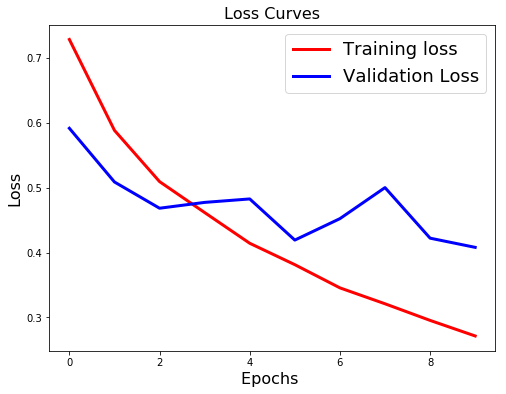

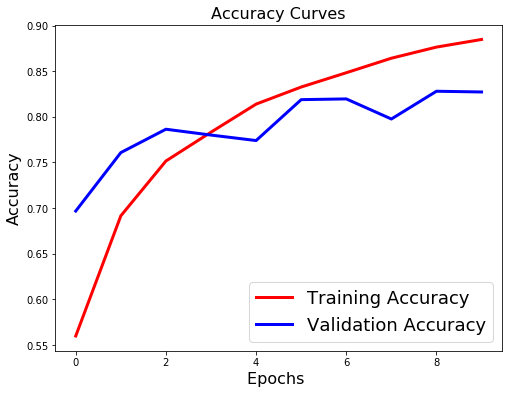

In [15]:
import matplotlib.pyplot as plt

print (history)
# Loss Curves
plt.figure(figsize=[8,6])
plt.plot(history.history['loss'],'r',linewidth=3.0)
plt.plot(history.history['val_loss'],'b',linewidth=3.0)
plt.legend(['Training loss', 'Validation Loss'],fontsize=18)
plt.xlabel('Epochs ',fontsize=16)
plt.ylabel('Loss',fontsize=16)
plt.title('Loss Curves',fontsize=16)
 
# Accuracy Curves
plt.figure(figsize=[8,6])
plt.plot(history.history['acc'],'r',linewidth=3.0)
plt.plot(history.history['val_acc'],'b',linewidth=3.0)
plt.legend(['Training Accuracy', 'Validation Accuracy'],fontsize=18)
plt.xlabel('Epochs ',fontsize=16)
plt.ylabel('Accuracy',fontsize=16)
plt.title('Accuracy Curves',fontsize=16)

In [14]:
# import numpy as np

# csv_array= np.array([(1, 1.2),(2, 2.3),(3, 3.4)])
# np.savetxt("array.csv", csv_array, fmt='%d,%f',delimiter=',', header="id,label", comments="")